In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
# code borrowed from: 
# https://github.com/garipovroma/speculation_for_reasoning/blob/main/src/train_head_gsm8k_nirvana.py

from typing import Union, Sequence, Tuple, Dict, Literal
import json
import os

from argparse import ArgumentParser
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

import pickle

import sys
sys.path.append('../src')
sys.path.append('..')

from core_utils import make_setup_slice_mapper, MODEL_TO_HIDDEN_DIM

def make_X_y(data: list[Dict], key='hiddens') -> Tuple[np.array, np.array]: 
    X = []
    y = []

    n_skip = 0
    skip_indexes = set()
    for sample_idx, sample_dict in enumerate(data):
        if 'hiddens' in sample_dict:
            assert len(sample_dict['changed_token_indices']) == len(sample_dict[key])
            x_ = [i.numpy() for i in sample_dict[key]]
            y_ = [int(i[1]) for i in sample_dict['changed_token_indices']]
            X.extend(x_)
            y.extend(y_)
        else:
            n_skip += 1
            skip_indexes.add(sample_idx)

        
    X = np.array(X)
    y = np.array(y)
    return X, y

class args:
    random_seed = 42
    train_size = 0.9
    data_path = 'gsm8k_1b_8b_0shot.pt'
    checkpoint_path = None
    target_model = 'meta-llama/Llama-3.1-8B-Instruct'
    draft_model = 'meta-llama/Llama-3.2-1B-Instruct'
    setup = 'DD-DT'
    remove_target_nones = False
    remove_draft_nones = False
    convert_to_vllm = False
    train_on_all_data = False
    uniform_thresholds = False
    remove_arena_duplicates = False
    concat_kostyl = False
    val_fold = -1

if args.convert_to_vllm:
    assert args.setup == 'DT', "autojudge vllm inference works in DT setup only"


data = torch.load(args.data_path)

if args.concat_kostyl:
    data = sum(data, [])

size_before_filtering = len(data)
print(f'Size of data: {len(data)}')
data = [i for i in data if type(i) == dict]
print(f'Size of data: {len(data)}, ∆size = {len(data) - size_before_filtering}')

if args.remove_target_nones:
    print(f'Size before target nones filtering: {len(data)}')
    data = [i for i in data if i['target_answer'] is not None and \
        type(i['target_answer']) == list and \
        type(i['target_answer'][0]) == str and \
        'none' not in i['target_answer'][0].lower() \
    ]
    print(f'Size after target nones filtering: {len(data)}')

if args.remove_draft_nones:
    print(f'Size before draft nones filtering: {len(data)}')
    data = [i for i in data if i['draft_answer'] is not None and \
        type(i['draft_answer']) == list and \
        type(i['draft_answer'][0]) == str and \
        'none' not in i['draft_answer'][0].lower() \
    ]
    print(f'Size after draft nones filtering: {len(data)}')

if args.remove_arena_duplicates:
    print(f'Size before arena duplicates filtering: {len(data)}')
    already_appeared = set()
    samples = []

    for i in data:
        if 'draft_gen_str' in i and i['draft_gen_str'] in already_appeared:
            continue
        already_appeared.add(i.get('draft_gen_str', "PLACEHOLDER"))
        samples.append(i)
    data = samples
    del already_appeared

    print(f'Size after arena duplicates filtering: {len(data)}')

np.random.seed(args.random_seed)
np.random.shuffle(data)

first_test_sample_idx = int(len(data) * args.train_size) + 1

train_data = data[:first_test_sample_idx]
test_data = data[first_test_sample_idx:]

if args.val_fold != -1:
    assert args.val_fold in range(5)
    assert not args.train_on_all_data
    folds = []
    root_dir = os.path.dirname(os.path.dirname(__file__))
    train_ids = []
    val_ids = []
    for fold_id in range(5):
        fold = torch.load(f"data/arena_hard_auto/creative_writing_fold_{fold_id}.pt")
        folds.append(fold)
        if fold_id == args.val_fold:
            val_ids.extend(fold)
        else:
            train_ids.extend(fold)

    train_ids = set(train_ids)
    val_ids = set(val_ids)
    intersection_sz = len(train_ids & val_ids)

    assert intersection_sz == 0, f"Data contamination found, train/val {intesection_sz=}"

    train_data = [i for i in data if i['id'] in train_ids]
    test_data = [i for i in data if i['id'] in val_ids]
    print(f'FOLD is specified, {args.val_fold=}')
    print(f'train_size = {len(train_data)}, val_size = {len(test_data)}')

X_train, y_train = make_X_y(train_data)
X_val, y_val = make_X_y(test_data)

SETUP_SLICE_MAP = make_setup_slice_mapper(args.draft_model, args.target_model)

setup_slice = SETUP_SLICE_MAP[args.setup]

X_train = X_train[:, setup_slice]
X_val = X_val[:, setup_slice]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

print(X_train.shape, X_val.shape)
print(y_train.mean(), y_val.mean())

Size of data: 7473
Size of data: 7473, ∆size = 0
(131594, 6144) (14135, 6144)
0.18943872820949284 0.18719490626105412


In [3]:
from matplotlib import pyplot as plt 
import matplotlib

matplotlib.rcParams.update({
    "font.family": "Times New Roman",
    "axes.labelsize": 16,
    "font.size": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    'axes.linewidth': 0.0
})
plt.figure (figsize=[16, 16])

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import cycle

C_grid = (10.) ** -np.arange(2, 6)[::-1]

dataframes = []

best_C = None
best_metric_roc_auc = -1
best_dataframe = None

best_model = None

colors = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5']))

best_auc = -1
best_C = None

params = []

models = []

for C, color in tqdm(zip(C_grid, colors), total=len(C_grid)):
    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)

    train_probs = model.predict_proba(X_train)[:, 1]
    val_probs   = model.predict_proba(X_val)[:, 1]
    
    auc_train = 0.0 if len(set(y_train)) < 2 else roc_auc_score(y_train, train_probs)
    auc_val   = 0.0 if len(set(y_val))   < 2 else roc_auc_score(y_val,   val_probs)
    
    print(f'C={C:.6f}, auc_train={auc_train:.6f}, auc_val={auc_val:.6f}')

    fpr_tr, tpr_tr, _ = roc_curve(y_train, train_probs) if len(set(y_train)) > 1 else (np.array([0,1]), np.array([0,1]), None)
    fpr_va, tpr_va, _ = roc_curve(y_val,   val_probs)   if len(set(y_val))   > 1 else (np.array([0,1]), np.array([0,1]), None)
    
    params.append((
        dict(
            x=fpr_va,
            y=tpr_va,
            linewidth=1.5,
            label=f"C={C:.0e}, AUC={auc_val:.3f}", 
            color=color
        ),
        dict(
            x=fpr_tr,
            y=tpr_tr,
            linestyle=":",
            linewidth=1.5,
            color=color,
            alpha=0.6
        ),
    ))
    
    if auc_val > best_auc:
        best_auc = auc_val
        best_C = C
        best_model = model
        best_model_params = params[-1]



  0%|          | 0/4 [00:00<?, ?it/s]

C=0.000010, auc_train=0.792132, auc_val=0.800792
C=0.000100, auc_train=0.826131, auc_val=0.811510


/home/garipovroma/autojudge_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C=0.001000, auc_train=0.847473, auc_val=0.802546


/home/garipovroma/autojudge_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C=0.010000, auc_train=0.851028, auc_val=0.792105


In [5]:
for params_tuple in params:
    for params_dict in params_tuple:
        params_dict['linewidth'] = 1.0

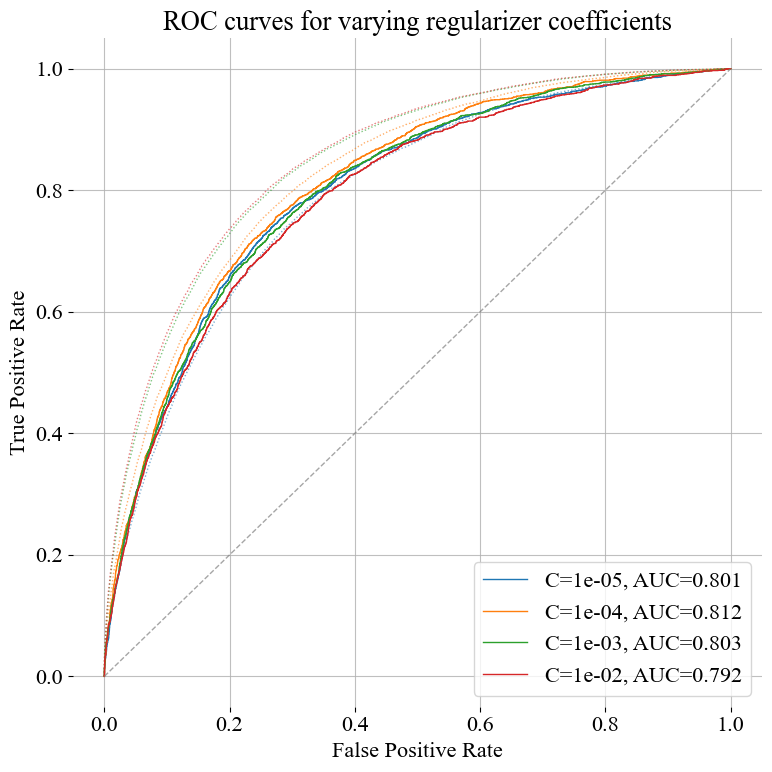

In [6]:
plt.figure (figsize=[8, 8])

for params_tuple in params:
    x0 = params_tuple[0].pop('x')
    y0 = params_tuple[0].pop('y')
    
    x1 = params_tuple[1].pop('x')
    y1 = params_tuple[1].pop('y')
    plt.plot(x0, y0, **params_tuple[0])
    plt.plot(x1, y1, **params_tuple[1])
    
    params_tuple[0]['x'] = x0
    params_tuple[0]['y'] = y0
    params_tuple[1]['x'] = x1
    params_tuple[1]['y'] = y1

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray", alpha=0.7)

plt.title("ROC curves for varying regularizer coefficients")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=True, fontsize=16)
plt.grid(alpha=0.8)
plt.tight_layout()
plt.savefig('figure_auc_regulizers.pdf')
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score

colors = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5']))

models = [
    ("Random Forest (n_estimators=128)", RandomForestClassifier(n_estimators=128, min_samples_leaf=0.001, random_state=42, n_jobs=-1)),
    ("MLP (hidden_layer_sizes=(128,))", MLPClassifier(hidden_layer_sizes=(128,), random_state=42, verbose=True, early_stopping=True)),
]

params_models_plot = []
best_auc = -1.0
best_name = None

X_train_ = X_train
y_train_ = y_train

for (name, model), color in zip(models, colors):
    model.fit(X_train, y_train)
    
    train_probs = model.predict_proba(X_train_)[:, 1]
    val_probs   = model.predict_proba(X_val)[:, 1]

    auc_train = 0.0 if len(set(y_train)) < 2 else roc_auc_score(y_train_, train_probs)
    auc_val   = 0.0 if len(set(y_val))   < 2 else roc_auc_score(y_val,   val_probs)

    print(f'{name}: auc_train={auc_train:.6f}, auc_val={auc_val:.6f}')

    fpr_tr, tpr_tr, _ = roc_curve(y_train_, train_probs) if len(set(y_train)) > 1 else (np.array([0,1]), np.array([0,1]), None)
    fpr_va, tpr_va, _ = roc_curve(y_val,   val_probs)   if len(set(y_val))   > 1 else (np.array([0,1]), np.array([0,1]), None)

    params_models_plot.append((
        dict(
            x=fpr_va,
            y=tpr_va,
            linewidth=1.0,
            label=f"{name}, AUC={auc_val:.3f}",
            color=color
        ),
        dict(
            x=fpr_tr,
            y=tpr_tr,
            linestyle=":",
            linewidth=1.0,
            color=color,
            alpha=0.6
        ),
    ))

    if auc_val > best_auc:
        best_auc = auc_val
        best_name = name
        
        
models = [best_model] + models
params_models_plot = [best_model_params] + params_models_plot

Random Forest (n_estimators=128): auc_train=0.856847, auc_val=0.766964
Iteration 1, loss = 0.46742839
Validation score: 0.825912
Iteration 2, loss = 0.36476052
Validation score: 0.829787
Iteration 3, loss = 0.34433512
Validation score: 0.828951
Iteration 4, loss = 0.32485805
Validation score: 0.825608
Iteration 5, loss = 0.30472335
Validation score: 0.823480
Iteration 6, loss = 0.27942523
Validation score: 0.825152
Iteration 7, loss = 0.25349747
Validation score: 0.824240
Iteration 8, loss = 0.22884343
Validation score: 0.818845
Iteration 9, loss = 0.20154899
Validation score: 0.812690
Iteration 10, loss = 0.17800314
Validation score: 0.811550
Iteration 11, loss = 0.15554223
Validation score: 0.814362
Iteration 12, loss = 0.13260783
Validation score: 0.806535
Iteration 13, loss = 0.11869593
Validation score: 0.806611
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLP (hidden_layer_sizes=(128,)): auc_train=0.869183, auc_val=0.799995


In [8]:
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

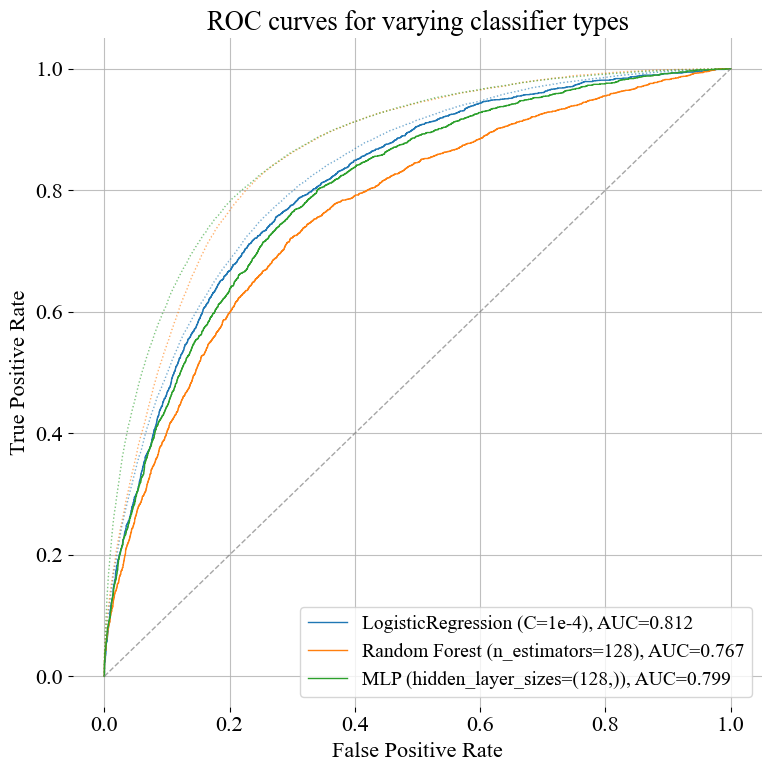

In [9]:
plt.figure(figsize=(8, 8))

params_models_plot[0] = best_model_params

for params_tuple in params_models_plot:
    x0 = params_tuple[0].pop('x'); y0 = params_tuple[0].pop('y')
    x1 = params_tuple[1].pop('x'); y1 = params_tuple[1].pop('y')
    if params_tuple[0]['label'] == 'C=1e-04, AUC=0.812' or 'Logistic' in params_tuple[0]['label']:
        params_tuple[0]['color'] = clrs[0]
        params_tuple[1]['color'] = clrs[0]
        params_tuple[0]['label'] = 'LogisticRegression (C=1e-4), AUC=0.812'
    if 'Random' in params_tuple[0]['label']:
        params_tuple[0]['color'] = clrs[1]
        params_tuple[1]['color'] = clrs[1]
    if 'MLP' in params_tuple[0]['label']:
        params_tuple[0]['color'] = clrs[2]
        params_tuple[1]['color'] = clrs[2]
        params_tuple[0]['label'] = 'MLP (hidden_layer_sizes=(128,)), AUC=0.799'
    plt.plot(x0, y0, **params_tuple[0])     # validation (bold)
    plt.plot(x1, y1, **params_tuple[1])     # training (dotted)
    params_tuple[0]['x'] = x0; params_tuple[0]['y'] = y0
    params_tuple[1]['x'] = x1; params_tuple[1]['y'] = y1

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray", alpha=0.7)

plt.title("ROC curves for varying classifier types")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=True, fontsize=14)
plt.grid(alpha=0.8)
plt.tight_layout()
plt.savefig('figure_auc_architectures.pdf')
plt.show()


## features ablation(token source)

In [24]:
slices = {
    'Previous token embeddings': {'key': 'prev_hiddens', 'slice': slice(0, 12288)},
    'Draft token embeddings': {'key': 'hiddens', 'slice': slice(0, 12288 // 2)},
    'Target token embeddings': {'key': 'hiddens', 'slice': slice(12288 // 2, 12288)},
    'Both token embeddings': {'key': 'hiddens', 'slice': slice(0, 12288)},
}

ERROR! Session/line number was not unique in database. History logging moved to new session 93


In [25]:
X_train, y_train = make_X_y(train_data)
X_val, y_val = make_X_y(test_data)

SETUP_SLICE_MAP = make_setup_slice_mapper(args.draft_model, args.target_model)

setup_slice = slice(0, 12288)

X_train = X_train[:, setup_slice]
X_val = X_val[:, setup_slice]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

print(X_train.shape, X_val.shape)
print(y_train.mean(), y_val.mean())

(131594, 12288) (14135, 12288)
0.18943872820949284 0.18719490626105412


In [26]:
best_C = None
best_metric_roc_auc = -1
best_dataframe = None

best_model = None

colors = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5']))

best_auc = -1
best_C = None

params = []

models = []


for (setup_name, slice_dict), color in zip(slices.items(), colors):
    dict_key = slice_dict.get('key')
    slice_ = slice_dict.get('slice')
    
    X_train, y_train = make_X_y(train_data, key=dict_key)
    X_val, y_val = make_X_y(test_data, key=dict_key)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    X_train = X_train[:, slice_]
    X_val = X_val[:, slice_]
    
    
    model = LogisticRegression(C=1e-4)
    model.fit(X_train, y_train)

    train_probs = model.predict_proba(X_train)[:, 1]
    val_probs   = model.predict_proba(X_val)[:, 1]

    auc_train = 0.0 if len(set(y_train)) < 2 else roc_auc_score(y_train, train_probs)
    auc_val   = 0.0 if len(set(y_val))   < 2 else roc_auc_score(y_val,   val_probs)
    
    print(f'{setup_name=}, auc_train={auc_train:.6f}, auc_val={auc_val:.6f}')

    fpr_tr, tpr_tr, _ = roc_curve(y_train, train_probs) if len(set(y_train)) > 1 else (np.array([0,1]), np.array([0,1]), None)
    fpr_va, tpr_va, _ = roc_curve(y_val,   val_probs)   if len(set(y_val))   > 1 else (np.array([0,1]), np.array([0,1]), None)

    params.append((
        dict(
            x=fpr_va,
            y=tpr_va,
            linewidth=1.0,
            label=f"{setup_name}, AUC={auc_val:.3f}", 
            color=color
        ),
        dict(
            x=fpr_tr,
            y=tpr_tr,
            linestyle=":",
            linewidth=1.0,
            color=color,
            alpha=0.6
        ),
    ))
    
    if auc_val > best_auc:
        best_auc = auc_val
        best_C = C
        best_model = model
        best_model_params = params[-1]


setup_name='Previous token embeddings', auc_train=0.838441, auc_val=0.813383
setup_name='Draft token embeddings', auc_train=0.826131, auc_val=0.811510
setup_name='Target token embeddings', auc_train=0.823554, auc_val=0.812249
setup_name='Both token embeddings', auc_train=0.852359, auc_val=0.820140


In [27]:
for params_tuple in params:
    for params_dict in params_tuple:
        params_dict['linewidth'] = 1.0

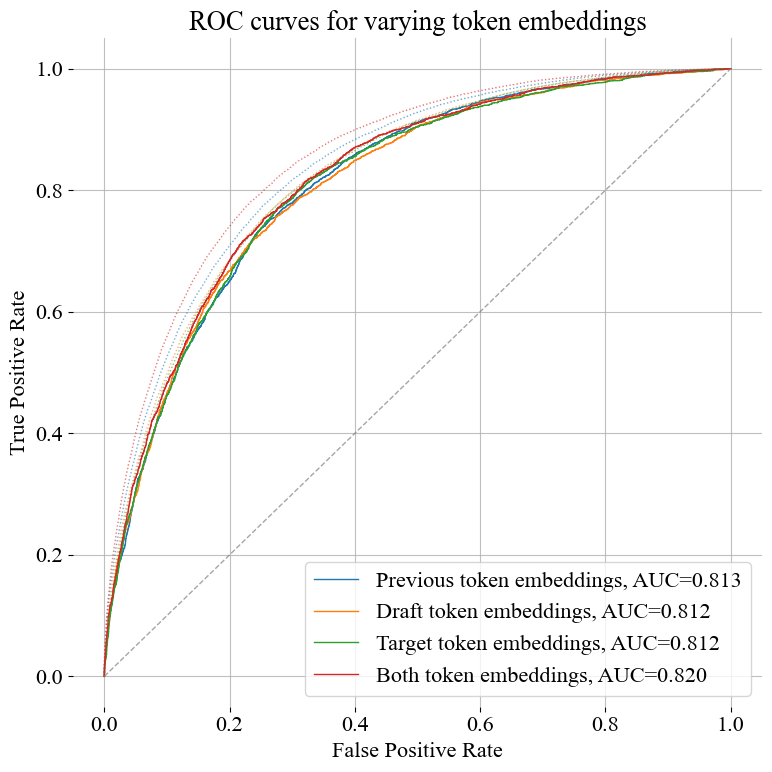

In [28]:
plt.figure(figsize=[8, 8])

for params_tuple in params:
    x0 = params_tuple[0].pop('x')
    y0 = params_tuple[0].pop('y')
    
    x1 = params_tuple[1].pop('x')
    y1 = params_tuple[1].pop('y')
    plt.plot(x0, y0, **params_tuple[0])
    plt.plot(x1, y1, **params_tuple[1])
    
    params_tuple[0]['x'] = x0
    params_tuple[0]['y'] = y0
    params_tuple[1]['x'] = x1
    params_tuple[1]['y'] = y1

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray", alpha=0.7)

plt.title("ROC curves for varying token embeddings")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=True, fontsize=16)
plt.grid(alpha=0.8)
plt.tight_layout()
plt.savefig('figure_auc_inputs.pdf')
plt.show()

## feature ablation, hiddens source

In [29]:
X_train, y_train = make_X_y(train_data)
X_val, y_val = make_X_y(test_data)

SETUP_SLICE_MAP = make_setup_slice_mapper(args.draft_model, args.target_model)

setup_slice = slice(0, 12288)

X_train = X_train[:, setup_slice]
X_val = X_val[:, setup_slice]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

print(X_train.shape, X_val.shape)
print(y_train.mean(), y_val.mean())

(131594, 12288) (14135, 12288)
0.18943872820949284 0.18719490626105412


In [30]:
slices = {
    'Draft model hiddens': {'key': 'hiddens', 'slice': slice(0, 2048)},
    'Target model hiddens': {'key': 'hiddens', 'slice': slice(2048, 2048 * 3)},
    'Both token embeddings': {'key': 'hiddens', 'slice': slice(0, 2048 * 3)},
}

In [31]:
best_C = None
best_metric_roc_auc = -1
best_dataframe = None

best_model = None

colors = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5']))

best_auc = -1
best_C = None

params = []

models = []


for (setup_name, slice_dict), color in zip(slices.items(), colors):
    dict_key = slice_dict.get('key')
    slice_ = slice_dict.get('slice')
    
    X_train, y_train = make_X_y(train_data, key=dict_key)
    X_val, y_val = make_X_y(test_data, key=dict_key)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    X_train = X_train[:, slice_]
    X_val = X_val[:, slice_]
    
    
    model = LogisticRegression(C=1e-4)
    model.fit(X_train, y_train)

    train_probs = model.predict_proba(X_train)[:, 1]
    val_probs   = model.predict_proba(X_val)[:, 1]

    auc_train = 0.0 if len(set(y_train)) < 2 else roc_auc_score(y_train, train_probs)
    auc_val   = 0.0 if len(set(y_val))   < 2 else roc_auc_score(y_val,   val_probs)
    
    print(f'{setup_name=}, auc_train={auc_train:.6f}, auc_val={auc_val:.6f}')

    fpr_tr, tpr_tr, _ = roc_curve(y_train, train_probs) if len(set(y_train)) > 1 else (np.array([0,1]), np.array([0,1]), None)
    fpr_va, tpr_va, _ = roc_curve(y_val,   val_probs)   if len(set(y_val))   > 1 else (np.array([0,1]), np.array([0,1]), None)

    params.append((
        dict(
            x=fpr_va,
            y=tpr_va,
            linewidth=1.0,
            label=f"{setup_name}, AUC={auc_val:.3f}", 
            color=color
        ),
        dict(
            x=fpr_tr,
            y=tpr_tr,
            linestyle=":",
            linewidth=1.0,
            color=color,
            alpha=0.6
        ),
    ))
    
    if auc_val > best_auc:
        best_auc = auc_val
        best_C = C
        best_model = model
        best_model_params = params[-1]


setup_name='Draft model hiddens', auc_train=0.775602, auc_val=0.773048
setup_name='Target model hiddens', auc_train=0.815264, auc_val=0.808296
setup_name='Both token embeddings', auc_train=0.826131, auc_val=0.811510


In [32]:
for params_tuple in params:
    for params_dict in params_tuple:
        params_dict['linewidth'] = 1.0

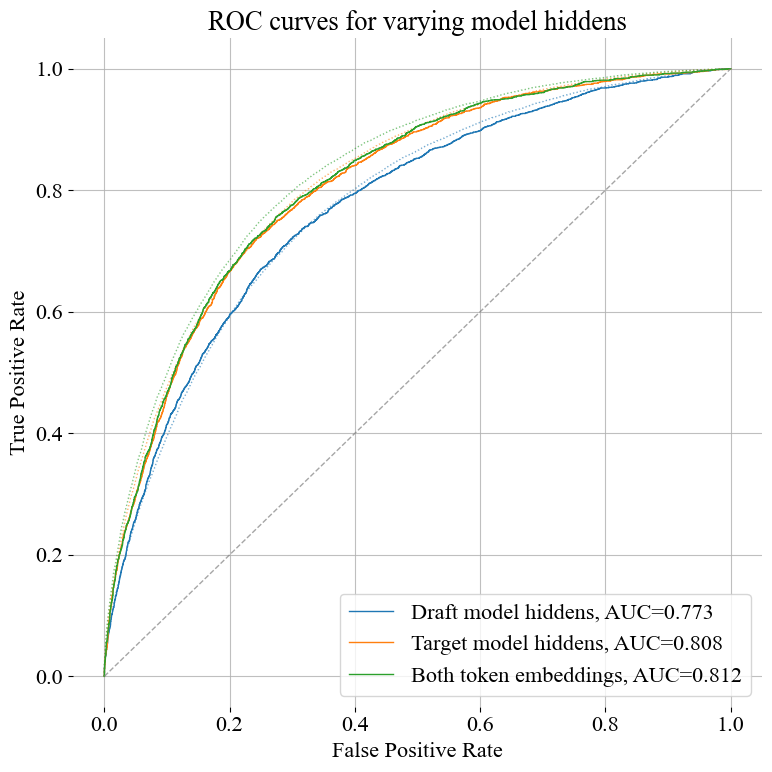

In [33]:
plt.figure(figsize=[8, 8])

for params_tuple in params:
    x0 = params_tuple[0].pop('x')
    y0 = params_tuple[0].pop('y')
    
    x1 = params_tuple[1].pop('x')
    y1 = params_tuple[1].pop('y')
    plt.plot(x0, y0, **params_tuple[0])
    plt.plot(x1, y1, **params_tuple[1])
    
    params_tuple[0]['x'] = x0
    params_tuple[0]['y'] = y0
    params_tuple[1]['x'] = x1
    params_tuple[1]['y'] = y1

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray", alpha=0.7)

plt.title("ROC curves for varying model hiddens")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=True, fontsize=16)
plt.grid(alpha=0.8)
plt.tight_layout()
plt.savefig('figure_auc_models.pdf')
plt.show()